In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import xarray as xr                                                                  
import numpy as np                                                                   
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys                                                                           
import os                                                                            
import glob                                                                          
from IPython.display import HTML
sys.path.append('../')
from shallowpy_plotting import arrange_axes, shade

## Initialize the model

In [3]:
# Initialize default parameters                                                      
# -----------------------------                                                      
exec(open('../shallowpy_defaults.py').read()) 

In [4]:
# Modify default parameters
# -------------------------
# run = __file__.split('/')[-1][:-3]
run = 'kelvin_wave'
path_data = f'/Users/nbruegge/work/movies/shallow_py/{run}/'                         
                                                                                     
nx = 100                                                                             
ny = 100                                                                             
nt = 2000                                                                            
#nt = 500                                                                            
#nt = 1                                                                              
                                                                                     
picture_frequency = 0                                                                
output_frequency = 20                                                                
diagnostic_frequency = output_frequency                                              
                                                                                     
dx = 10e3                                                                            
dy = dx                                                                              
#dt = 360.                                                                           
                                                                                     
#grav = 9.81                                                                         
grav = 0.02                                                                          
rho = np.array([1024.])                                                              
nz = rho.size                                                                        
                                                                                     
H0 = 100.                                                                            
cph = np.sqrt(grav*H0)
dist = dt*nt * cph
dt  = 0.1*dx/np.sqrt(grav*H0)

nspx = 1
nspy = 1
epsab = 0.01

kh = 1000.
Ah = kh

f0 = 1e-4
beta = 0.*1e-11

do_momentum_advection = False
do_momentum_diffusion = False
do_momentum_coriolis_exp = False
do_momentum_coriolis_imp = True
do_momentum_pressure_gradient = True
do_height_diffusion = False

In [5]:
# Initialize the grid and initial conditions
# ------------------------------------------
exec(open('../shallowpy_grid_setup.py').read())

In [6]:
# Modify initial conditions
# -------------------------
eta0[0,:,:] = 0.1*np.exp(-((Xt-0.5*Lx)**2+(Yt-Ly)**2)/(1.e-3*(Lx**2+Ly**2)))
eta0[1,:,:] = -H0

ho0 = eta0[:-1,:,:]-eta0[1:,:,:]

maskt0[:,0,:] = 0.
maskt0[:,-1,:] = 0.
maskt0[:,:,0] = 0.
maskt0[:,:,-1] = 0.

ix = np.array([nx//2])
iy = np.array([1*ny//4])

## Run the model

In [7]:
# Run the model
# -------------
exec(open('../shallowpy_main.py').read())

ll =   1980/  2000, Total run time: 0.27min, done at 2022-08-26 13:03:26.223184, ho.sum = 9.6e+05, ke.sum = 5.5e-07, cflu = 1.4e-05, cflv = 5.4e-06
--- All done! ---
Total run time: 0.27min, done at 2022-08-26 13:03:26.300215
------


## Post-process the result

In [8]:
# Do post-processing
# ------------------
exec(open('../pp_main.py').read())

In [9]:
%%time
# Combine all netcdf files
# ------------------------
#if output_frequency>0:
if True:
    mfdset_kwargs = dict(combine='nested', concat_dim='time',
        data_vars='minimal', coords='minimal', compat='override', join='override',
        parallel=True
    )
    ds = xr.open_mfdataset(f'{path_data}/{file_prfx}_????.nc', **mfdset_kwargs)
    fpath = f'{path_data}/{file_prfx}_combined.nc'
    print(f'Save file {fpath}')
    ds['ho'] = ds.ho.where(masktp==1)
    ds['uo'] = ds.uo.where(maskup==1)
    ds['vo'] = ds.vo.where(maskvp==1)
    ds.to_netcdf(fpath)

Save file /Users/nbruegge/work/movies/shallow_py/kelvin_wave//shallowpy_combined.nc
CPU times: user 3.16 s, sys: 799 ms, total: 3.96 s
Wall time: 3.5 s


## Plot overview

In [10]:
nps = ds.time.size
nps

100

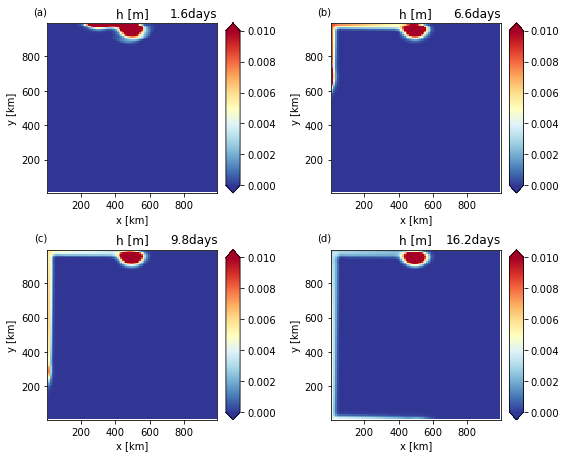

In [11]:
# prepare the animation
iz = 0
steps = [10, 40, 60, 99]

hca, hcb = arrange_axes(2,2, plot_cb=True, asp=1., fig_size_fac=1.5,
                        sharex=False, sharey=False, xlabel='x [km]', ylabel='y [km]')
ii=-1

for nn, ll in enumerate(steps):
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    data = ds['ho'][ll,iz,:,:].compute()
    clim = [0, 1e-2]
    hm = shade(ds.xt/1e3, ds.yt/1e3, data-H0, ax=ax, cax=cax, clim=clim)
    ax.set_title('h [m]')
    ht = ax.set_title(f'{ds.time[ll].data/86400.:.1f}days', loc='right')

## Make an animation

In [12]:
path_fig = f'{path_data}/'
fname_prf = run
fpath = f'{path_data}/shallowpy_combined.nc'

mfdset_kwargs = dict(combine='nested', concat_dim='time',
                     data_vars='minimal', coords='minimal', compat='override', join='override',
                    )
ds = xr.open_mfdataset(fpath, **mfdset_kwargs)
#ds = ds.compute()

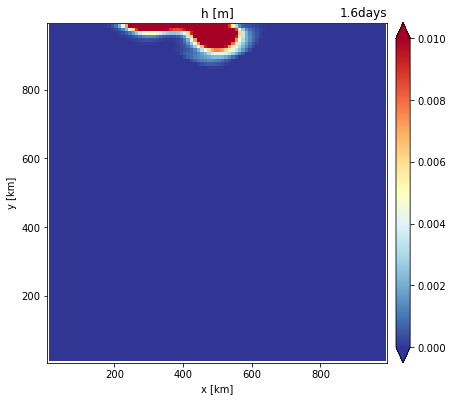

In [13]:
# prepare the animation

iz = 0
ll=10

hca, hcb = arrange_axes(1,1, plot_cb=True, asp=1.00, fig_size_fac=3, axlab_kw=None,
                        sharex=False, sharey=False, xlabel='x [km]', ylabel='y [km]')
ii=-1
fig = plt.gcf()

ii+=1; ax=hca[ii]; cax=hcb[ii]
data = ds['ho'][ll,iz,:,:].compute()
clim = [0, 1e-2]
hm = shade(ds.xt/1e3, ds.yt/1e3, data-H0, ax=ax, cax=cax, clim=clim)
ax.set_title('h [m]')
ht = ax.set_title(f'{ds.time[ll].data/86400.:.1f}days', loc='right')

In [14]:
# function for updating the animation
def run(ll):
    print(f'll = {ll} / {ds.time.size}', end='\r')
    data = ds['ho'][ll,iz,:,:].data - H0
    hm[0].set_array(data.flatten())
    ht.set_text(f'{ds.time[ll].data/86400.:.1f}days')

In [15]:
%%time
# --- save the animation
ani = animation.FuncAnimation(fig, run, ds.time.size)
if not os.path.exists(path_fig):
    os.mkdir(path_fig)
fpath_fig = f'{path_fig}/{fname_prf}.mp4'
print(f'Saving {fpath_fig}')
ani.save(fpath_fig, writer='ffmpeg', fps=40)

Saving /Users/nbruegge/work/movies/shallow_py/kelvin_wave///kelvin_wave.mp4
CPU times: user 8.69 s, sys: 774 ms, total: 9.47 s
Wall time: 10.3 s


## Showing the animation

In [16]:
%%time
HTML(ani.to_jshtml())

CPU times: user 8.09 s, sys: 563 ms, total: 8.66 s
Wall time: 9.16 s
